# Multi-Scenario MORDM Analysis
Step 3 of the analysis involves multi-scenario multi-objective robust decision making. Here, optimization is done with the selected worst case scenarios to generate candidate solutions. This is done with the following steps:
- First, the optimization from ema_workbench is ran on the DelftBlue supercomputer for all 5 worst case scenario, and per scenario for 3 seeds.
- The results are exported from DelftBlue and imported and combined in this file.
- The epsilon progress is evaulated for each run, to check whether stabilization has occured.
- All the candidate solutions are then merged based on epsilon non-dominance.
- Finally, the best solutions based on lowest deaths are chosen for further analysis and the solution space is explored.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from ema_workbench import (
    Model,
    Policy,
    Scenario,
    ema_logging,
    ScalarOutcome
)

import pickle
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem, epsilon_nondominated,
                                                     rebuild_platypus_population)

## Combining Files from DelftBlue

As optimization is quite computationally intensive, the optimization is ran on the DelftBlue supercomputer [(DelftBlue, n.d.)](https://doc.dhpc.tudelft.nl/delftblue/). However, there were problems with getting the MPIEvaluator to run and the queue was too long to claim an exlusive node for using the MultiprocessingEvaluator, so we came up with a workaround: running several SequentialEvaluators in parallel. That way, we could still do optimization with high nfe values. For each scenario, a seperate optimization process was set up, which ran the optimization for 3 seeds with 100000 nfe. This resulted in 5 seperate files, which were saved as Python lists with the Python pickle package. Below, they are combined to be one list. Next to that, the model is defined once again, which is necessary to use the EMA Workbench epsilon merge function. The code that ran on DelftBlue is included in a seperate .py file in the assignment.

The model is defined using our custom problem formulation. In the optimization, the expected annual damage, expected number of deaths and the dike investment costs are minimized for A2, next to the RfR Total Costs. This poses a dilemma: how can you ensure minimal damage and minimal deaths without it costing too much? As for the epsilon values, which indicate how big of a step the optimization algorithm considers as an improvement, we have chosen 1000 for every outcome except for deaths: this is due to the the other outcomees being costs with a high magnitude, while the deaths were always generally low when testing the optimization. Finally, all levers are included, as we want don't want to exclude any lever that could be of interest just yet.

In [4]:
dike_model, planning_steps = get_model_for_problem_formulation(6)
epsilons = [1000, 1000, 0.25, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

# Specifying which outcomes we want to optimize for
# fuction=sum is used, because our problem formulation requires aggregating over timesteps 
dike_model.outcomes = [ScalarOutcome("A.2_Expected Annual Damage", kind=ScalarOutcome.MINIMIZE, function=sum),
                       ScalarOutcome("A.2_Expected Number of Deaths", kind=ScalarOutcome.MINIMIZE, function=sum),
                       ScalarOutcome("A.2_Dike Investment Costs", kind=ScalarOutcome.MINIMIZE, function=sum),
                       ScalarOutcome("RfR Total Costs", kind=ScalarOutcome.MINIMIZE, function=sum)]

# Candidate solutions should be policy, which is why levers are being searched over
problem = to_problem(dike_model, searchover="levers")


In [5]:
# Loading and combining the results from the optimization
with open('scenario_results/resultsFile_1', mode='rb') as f:
    s1 = pickle.load(f)

with open('scenario_results/resultsFile_2', mode='rb') as f:
    s2 = pickle.load(f)

with open('scenario_results/resultsFile_3', mode='rb') as f:
    s3 = pickle.load(f)

with open('scenario_results/resultsFile_4', mode='rb') as f:
    s4 = pickle.load(f)

with open('scenario_results/resultsFile_5', mode='rb') as f:
    s5 = pickle.load(f)

with open('scenarioList', mode='rb') as f:
    scenario_list = pickle.load(f)

In [6]:
results = s1 + s2 + s3 + s4 + s5

In [7]:
# results is a list of tuples for every scenario: containing a list of dataframes with results and a list of dataframes with convergence data
results

[([     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
   0          0        0        0        0        0        0        1        0   
   1          0        0        0        0        0        0        0        0   
   2          0        0        0        0        0        0        0        0   
   3          0        0        0        0        0        0        0        0   
   4          0        0        0        0        0        0        0        0   
   ..       ...      ...      ...      ...      ...      ...      ...      ...   
   103        0        0        0        0        0        0        1        1   
   104        0        0        0        0        0        0        1        1   
   105        0        0        0        0        0        0        1        1   
   106        0        0        0        0        0        0        1        1   
   107        0        0        0        0        0        0        0        0   
   
        2_Rf

## Evaluating the Convergence

Now that the files are combined, the performance of the optimization algorithm can be evaluated by looking at the epsilon progress metric. Next to the candidate solutions, the optimization has output archives contained the epsilon progress per nfe for each optimization run. In this code, which is based on code on the course's GitHub repository [(Kwakkel, 2024)](https://github.com/quaquel/epa141A_open/blob/master/Week%205-6%20-%20robustness%20and%20direct%20search/assignment%2010%20-%20model%20answer.ipynb), the epsilon progress values are unpacked from the archives and plotted with a seperate color per scenario. 

In the graph below, we can see that the epsilon progress for every scenario has stabilized, which means that the optimization reached a 'plateau' in its performance, so higher nfe values are not necessary for better solutions. There are slight differences between the scenarios though. It seems that scenario 2 converges slower than the other scenarios, and it seems that for this scenario, more stabilization may occur with a slightly higher nfe. However, the nfe value seems more than sufficient for every other scenario as indicated by the early convergence.

./archives/1_seed_0.tar.gz
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
Index removed.
./archives/1_seed_1.tar.gz
Index removed.
I

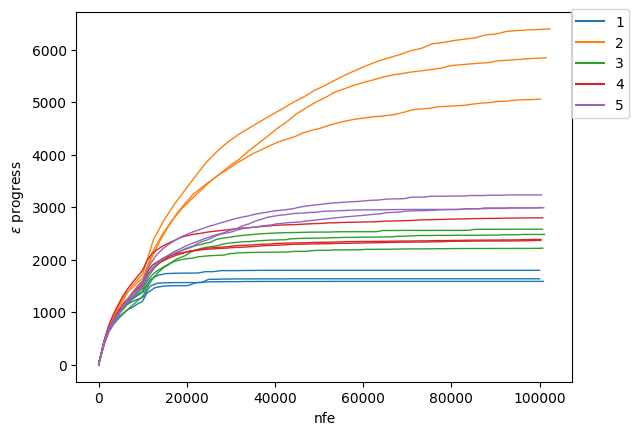

In [8]:
def calculate_convergence_metrics(problem, archives_file):
    archives = ArchiveLogger.load_archives(archives_file)
    # First, an unwanted index column has to be removed in every df in the archives
    for key in archives:
        print('Index removed.')
        if 'Unnamed: 0' in archives[key].columns:
            archives[key] = archives[key].drop(columns=['Unnamed: 0'])

    # Relevant metrics are added to a dictionary to be plotted 
    metrics = []
    for nfe, archive in archives.items():
        population = rebuild_platypus_population(archive, problem)
        metrics.append(dict(nfe=nfe))

        
    metrics = pd.DataFrame.from_dict(metrics)
    metrics.sort_values(by="nfe", inplace=True, ignore_index=True)    
    return metrics

# Calculating convergence with the archives
problem = to_problem(dike_model, searchover="levers")
convergence_calculations = []
for (refset, eps_progress), scenario in zip(results, scenario_list):
    for seed, seed_eps in zip(range(5), eps_progress):
        archive_file = f"./archives/{scenario.name}_seed_{seed}.tar.gz"
        print(archive_file)
        metrics = calculate_convergence_metrics(problem, archive_file)
        metrics["seed"] = seed
        metrics["scenario"] = scenario.name
        metrics["epsilon_progress"] = seed_eps.epsilon_progress   
        
        convergence_calculations.append(metrics)
convergence = pd.concat(convergence_calculations, ignore_index=True)

fig, ax2 = plt.subplots()

colors = sns.color_palette()

# Adding a legend, seperating by scenario
legend_items = []
for (scenario_name, scores), color in zip(convergence.groupby("scenario"), colors):
    legend_items.append((mpl.lines.Line2D([0, 0], [1, 1], c=color), scenario_name))
    for seed, score in scores.groupby("seed"):
        ax2.plot(score.nfe, score.epsilon_progress, c=color, lw=1)

ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')

artists, labels = zip(*legend_items)
fig.legend(artists, labels, bbox_to_anchor=(1,0.9))

plt.show()


# Data Filtering for Final Candidate Solutions
Now that the convergence has been evaluated, we can work towards a final list of candidate solutions: the selection of policies from which we choose the final recommendation(s). First, the different dataframes with solutions per seed for every dataframe are merged with the epsilon non-dominated function of the EMA Workbench, which uses the epsilon values used in the model to only keep the solutions which aren't dominated based on the pareto front. Then, these dataframes are once again merged using the same function. The outcome is one dataframe containing 88 solutions.

In [9]:
all_results = []
for i in range(len(results)):
    #appending the merged list with dominant results for every scenario
    dominating_solutions_per_scenario = epsilon_nondominated(results[i][0], epsilons, problem)
    all_results.append(dominating_solutions_per_scenario)

In [10]:
# merging solutions for all scenarios based on dominance
all_dominating_solutions = epsilon_nondominated(all_results, epsilons, problem)

In [11]:
all_dominating_solutions

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,RfR 0 Individual Costs,RfR 1 Individual Costs,RfR 2 Individual Costs,RfR 3 Individual Costs,RfR 4 Individual Costs
0,0,0,0,0,0,0,1,0,0,1,...,2.723911e+08,0.0,0.283718,151900000.0,0.00000,0.0,0.0,30699999.0,121200000.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,5.096416e+08,0.0,0.528579,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,1,...,3.543357e+08,0.0,0.370914,121200000.0,0.00000,0.0,0.0,0.0,121200000.0,0.0
3,0,0,0,0,0,0,0,0,0,1,...,3.543357e+08,0.0,0.133529,121200000.0,11498.30149,0.0,0.0,0.0,121200000.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,3.158712e+08,0.0,0.330146,242400000.0,0.00000,0.0,0.0,0.0,242400000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0,0,0,0,0,0,0,0,0,1,...,2.470588e+07,47842699.0,0.019556,363600000.0,0.00000,0.0,0.0,0.0,363600000.0,0.0
84,0,0,0,0,0,0,0,0,0,1,...,9.061956e+06,53358573.0,0.007276,242400000.0,0.00000,0.0,0.0,0.0,242400000.0,0.0
85,0,0,0,0,0,0,1,0,1,1,...,1.753332e+06,47842699.0,0.001369,681100000.0,0.00000,0.0,0.0,61399998.0,363600000.0,256099998.0
86,0,0,0,0,0,0,1,1,0,1,...,3.853284e+07,42818415.0,0.029498,559900000.0,0.00000,0.0,0.0,61399998.0,242400000.0,256099998.0


Now the solutions are filtered on whether RfR 2 and RfR 3 are on in any timestep. This is because, for our actor, these location matter the most as they relate to dike ring A2. We want to have Room for River on in our solutions, as Room for River is a nature-based solution that our actor, the water board, is a advocate for. Unfortunately, the model doesn't have other levers or outcomes related to quality of nature, for which our actor is concerned, as further described in the report. There are 41 solutions that have RfR 2 and 3.

In [12]:

# Filtering the dataframe with RfR turned on in at least one of the three timesteps.
filtered_df = all_dominating_solutions[
    (
        (all_dominating_solutions['2_RfR 0'] == 1) | (all_dominating_solutions['2_RfR 1'] == 1) | (all_dominating_solutions['2_RfR 2'] == 1)
    ) &
    (
        (all_dominating_solutions['3_RfR 0'] == 1) | (all_dominating_solutions['3_RfR 1'] == 1) | (all_dominating_solutions['3_RfR 2'] == 1)
    )
]


In [13]:
filtered_df

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,RfR 0 Individual Costs,RfR 1 Individual Costs,RfR 2 Individual Costs,RfR 3 Individual Costs,RfR 4 Individual Costs
0,0,0,0,0,0,0,1,0,0,1,...,2.723911e+08,0.000000e+00,0.283718,151900000.0,0.000000,0.0,0.0,30699999.0,121200000.0,0.0
5,0,0,0,0,0,0,0,0,1,1,...,2.382743e+08,0.000000e+00,0.247919,273100000.0,0.000000,0.0,0.0,30699999.0,242400000.0,0.0
6,0,0,0,0,0,0,1,0,1,1,...,1.665598e+08,0.000000e+00,0.173028,303800000.0,0.000000,0.0,0.0,61399998.0,242400000.0,0.0
7,0,0,0,0,0,0,1,0,1,0,...,2.015785e+08,0.000000e+00,0.209179,182600000.0,0.000000,0.0,0.0,61399998.0,121200000.0,0.0
15,0,0,0,0,0,0,1,0,0,1,...,5.539666e+07,4.281842e+07,0.060881,273100000.0,0.000000,0.0,0.0,30699999.0,242400000.0,0.0
17,0,0,0,0,0,0,1,1,1,1,...,1.015334e+08,0.000000e+00,0.105115,455700000.0,0.000000,0.0,0.0,92100000.0,363600000.0,0.0
18,0,0,0,0,0,0,1,0,1,1,...,6.486249e+07,3.824512e+07,0.069517,425000000.0,0.000000,0.0,0.0,61399998.0,363600000.0,0.0
20,0,0,0,0,0,0,0,0,1,0,...,1.325746e+08,3.824512e+07,0.142302,151900000.0,0.000000,0.0,0.0,30699999.0,121200000.0,0.0
21,0,0,0,0,0,0,1,0,1,1,...,1.457616e+08,0.000000e+00,0.151237,425000000.0,0.000000,0.0,0.0,61399998.0,363600000.0,0.0
23,0,0,0,0,0,0,1,0,0,1,...,2.030459e+08,0.000000e+00,0.211397,394300000.0,0.000000,0.0,0.0,30699999.0,363600000.0,0.0


To further trim down the selection of candidate policies, the dataframe is sorted by expected number of deaths. As seen in the PRIM analysis, expected annual damage and expected number of deaths are closely related, so for now, the dataframe is sorted based on only number of deaths. As the waterboard cares about the limiting the consequences of climate change, and therefore floods, it is assumed that they mostly care about preventing damage and deaths, and care not so much about the economic factors (costs). The reason the costs were included in the optimization was that, otherwise, the optimization would go to extreme and unrealistic lengths to prevent any damage or deaths and there would be no dillema. Finally, we take the top 10 of the newly sorted dataframe and consider it the solution space. 

Evaluating the newly created dataframe, it seems that policy 52 and policy 54 are promising, because they both have zero deaths and zero damage, furthermore, expected evacuation costs are zero and the RfR total costs are not the highest compared to other policies. A downside are the dike investment costs, which are on the higher side, but not exceptionally high compared to the other policies. These outcomes are only based on one scenario though, which is why the robustness still has to be calculated and taken into account for the final recommendation(s).

In [14]:
sorted_filtered_df = filtered_df.sort_values(by='A.2_Expected Number of Deaths')
top_10_lowest_values_df = sorted_filtered_df.head(10)
top_10_lowest_values_df

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,RfR 0 Individual Costs,RfR 1 Individual Costs,RfR 2 Individual Costs,RfR 3 Individual Costs,RfR 4 Individual Costs
52,0,0,0,0,0,0,1,1,1,0,...,0.000000e+00,4.784270e+07,0.000000,334500000.0,0.000000,0.0,0.0,92100000.0,242400000.0,0.0
54,0,0,0,0,0,0,1,0,0,1,...,0.000000e+00,5.335857e+07,0.000000,273100000.0,0.000000,0.0,0.0,30699999.0,242400000.0,0.0
79,0,0,0,0,0,0,1,0,1,1,...,1.753332e+06,4.784270e+07,0.000493,425000000.0,14114.350180,0.0,0.0,61399998.0,363600000.0,0.0
66,0,0,0,0,0,0,1,1,1,0,...,1.740172e+06,4.784270e+07,0.001355,213300000.0,0.000000,0.0,0.0,92100000.0,121200000.0,0.0
85,0,0,0,0,0,0,1,0,1,1,...,1.753332e+06,4.784270e+07,0.001369,681100000.0,0.000000,0.0,0.0,61399998.0,363600000.0,256099998.0
73,0,0,0,0,0,0,0,0,1,0,...,1.871766e+06,5.335857e+07,0.001499,151900000.0,0.000000,0.0,0.0,30699999.0,121200000.0,0.0
65,0,0,0,0,0,0,1,1,1,1,...,1.262657e+07,4.281842e+07,0.003451,455700000.0,14380.300466,0.0,0.0,92100000.0,363600000.0,0.0
48,0,0,0,0,0,0,1,1,0,1,...,8.443244e+06,4.784270e+07,0.006591,303800000.0,0.000000,0.0,0.0,61399998.0,242400000.0,0.0
49,0,0,0,0,0,0,1,0,1,0,...,8.570102e+06,4.784270e+07,0.006731,182600000.0,0.000000,0.0,0.0,61399998.0,121200000.0,0.0
72,0,0,0,0,0,0,1,1,1,1,...,1.262657e+07,4.281842e+07,0.009586,967900000.0,0.000000,0.0,0.0,92100000.0,363600000.0,512199999.0


In [17]:
top_10_lowest_values_df['A.2_DikeIncrease 0']

52    3
54    4
79    3
66    3
85    3
73    4
65    2
48    3
49    3
72    2
Name: A.2_DikeIncrease 0, dtype: int64

In [32]:
# Saving the top 10 solutions with lowest deaths, so robustness can be calculated. 
with open('dominatingSolutions', 'wb') as f:
    pickle.dump(top_10_lowest_values_df, f)

In [37]:
def plot_min_max_mean(df):
    """Function to plot the ranges and the means of a dataframe with policies"""
    fig, ax = plt.subplots()

    for i, column in enumerate(df.columns):
        min_val = df[column].min()
        max_val = df[column].max()
        mean_val = df[column].mean()
        
        ax.bar(i, max_val - min_val, bottom=min_val, color='skyblue', edgecolor='black')
        
        ax.plot(i, mean_val, 'ro')
        
        ax.text(i, mean_val + 0.3, f'{mean_val:.2f}', ha='center', va='bottom', rotation = 90)

    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=90)

    plt.tight_layout()

    plt.show()


The top 10 solutions with lowest deaths are considered the solution space for now. Below, the ranges of the lever values for the top 10 are plotted. Because with policy, specific policies are hard to implement, having insights in the ranges of lever values that lead to the best outcomes can be insightful. The plot makes for interesting conclusions. First of all, and to no surprise as it was the filter condition, every solution has RfR 2 and 3 turned on. We do see some differences in in which timestep RfR is introduced. For RfR 2, it seems that in most solutions it is introduced in timestep 0 or 2, as indicated by the higher mean of these timesteps. For RfR 3, however, timestep 1 seems to be the popular option. Unfortunately, in our problem formulation, the outcomes are aggregated over time so the model cannot provide specific insights in how outcomes change through timesteps. RfR 0 and 1 remain off in all policies, which means that they don't seem important in preventing floods at A2. Finally, RfR 4 is only introduced in some policies, which also indicates less importance for A2. 

Furthermore, due to the low mean and max of EWS_DaysToThreat, it seems like warnings beforehand don't have much influence on outcomes, which could be due to potential false warnings being less effective. As for the dike increases, on average across all dikes, there is a dike increase of 2.7m, which is quite moderate, which is something that is preferred by the water board as dike increases lead to emissions and nature-based solutions are preferred to protect the quality of nature, which is further described in the Literature Review. However, there are large differences between the ranges of dike increases of different dikes. In all policies, A1 doesn't get an increase, which can be explained by the conclusion of the PRIM analysis. If A1 becomes too strong, the water force will increase at A2, potentially leading to a dike failure. As for the increase of dike ring A2 itself, an increase of around 3 meters is recommended, at timestep 0. Due to the small range of this variable across the different solutions, it can be considered important for the outcomes. The ranges of the other dike increase variables are high, indicating that the specific values that they take on are less critical to the outcomes and vary a lot across the candidate policies. 

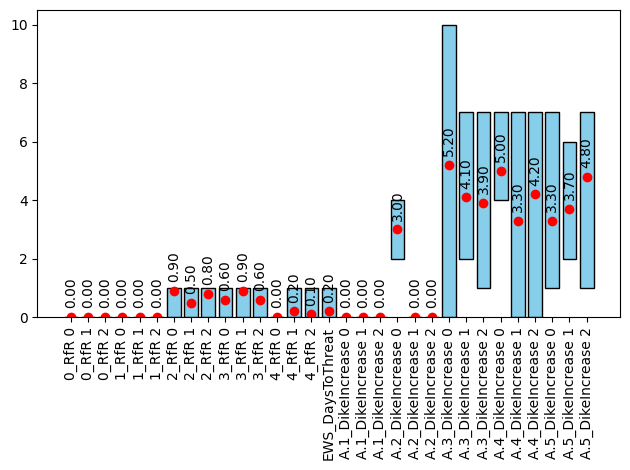

In [39]:
# To see the visualize the ranges of the policies, the columns with the outcomes are dropped 
solution_space = top_10_lowest_values_df.drop(columns=['A.2_Expected Annual Damage', 'A.2_Dike Investment Costs',
       'A.2_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs', 'RfR 0 Individual Costs',
       'RfR 1 Individual Costs', 'RfR 2 Individual Costs',
       'RfR 3 Individual Costs', 'RfR 4 Individual Costs'])
plot_min_max_mean(solution_space)

# Wide ranges indicate less impact on final outcomes

In [41]:
dike_increase = solution_space[['A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']]

print('Average dike increase across all dikes:', np.mean(dike_increase.values))

Average dike increase accross all dikes: 2.7


To further evaluate the candidate policies, the top 10 policies with least deaths are taken to the next step: calculating robustness across a wide range of scenarios.